# Cкрипт для обработки файла рекламаций

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sn
import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## Вспомогательные переменные

In [3]:
# Сегодняшний день
today = datetime.date.today()
# Сегодняшний день недели
today_weekday = today.strftime('%A')
# Вчерашняя дата, позавчерашняя, позапозавчерашняя
yesterday = today - datetime.timedelta(days=1)
the_day_before_yeasterday = today - datetime.timedelta(days=2)
two_days_before_yeasterday = today - datetime.timedelta(days=3)
three_days_before_yeasterday = today - datetime.timedelta(days=4)
# Список ЛЦ
LC = ['Воронеж','Казань','Котельники','МЯ','Новосибирск','Ростов','Самара','СЗ', 'Урал','ЦПП']
# пусть в директорию архива
archive_path_not_ready =f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\Архив\\{today} Не закрытые товарные.xlsx"
archive_path_not_ready_non_marketable = f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\Архив\\{today} Качество обслуживания.xlsx"

## Подгрузка исходников

encoding='cp1251' 
encoding='utf-8'

In [4]:
# загрузка построчного файла рекламаций
raw_compliants_lines = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\yyy.csv",
                                   encoding='utf-8', dtype={'Описание претензии': str}, low_memory=False, sep=';')
# загрузка файла рекламаций
raw_compliants = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\xxx.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')
# загрузка файла с нетоварными обращениями
raw_non_marketable = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\zzz.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')

# Чтение и загрузка ВПР, создание слоарей из файлов
# ЛЦ
VPR_compliants_lines_lc = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР построчный ЛЦ.xlsx")
key_compliants_lines_lc = dict(zip(VPR_compliants_lines_lc['Текст'], VPR_compliants_lines_lc['Значение']))
# ЛЦ для нетоварных
VPR_non_marketable = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР нетоварные ЛЦ.xlsx")
key_non_marketable = dict(zip(VPR_non_marketable['Текст'], VPR_non_marketable['Значение']))
# Маркер этапа построчный
VPR_compliants_lines_stage_marker = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР построчный маркер этапа.xlsx")
key_compliants_lines_stage_marker = dict(zip(VPR_compliants_lines_stage_marker['Текст'],
                                            VPR_compliants_lines_stage_marker['Значение']))
# Маркер этапа рекламации
VPR_compliants_stage_marker = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР рабочий маркер этапа.xlsx")
key_compliants_stage_marker = dict(zip(VPR_compliants_stage_marker['Текст'],
                                            VPR_compliants_stage_marker['Значение']))
# Таймер контроля для незавершенных
VPR_control_timer = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР таймер контроля.xlsx")
key_control_timer = dict(zip(VPR_control_timer['Текст'],
                                            VPR_control_timer['Значение']))

In [5]:
raw_compliants_lines

,Id процесса,Id родительского процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Описание,Комментарий,Производитель,Код производителя,Код товара,Описание товара,Класс 33,Цена за ед. измерения без НДС,Исполнитель текущего этапа,Текущий этап,Решение,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Кол-во товара,Уход,Результат возврата/обмена/довоза,Ожидает ответа поставщика,ФИО сотр. допуст. ошибку,Должн. сотр. допуст. ошибку,Описание ошибки,Кто определил допуст. ошибку
0,2319880,2319879,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,"Шнур коммутационный категории 5Е UTP 0,5м серы...",Просьба осуществить возврат исправного товара ...,Generica,1019,320026,"Шнур коммутационный категории 5Е UTP 0,5м серы...",17009,30.97,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,26.02.2023 06:36:06,0,-54.0,S,Да,NaN,NaN,NaN,NaN,NaN
1,2319884,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Ввод кабельный для труб IP55 диаметр 32мм,NaN,DKC,138,9668083,Ввод кабельный для труб IP55 диаметр 32мм,163032,15.44,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,26.02.2023 06:43:36,0,-80.0,S,Да,NaN,NaN,NaN,NaN,NaN
2,2319883,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Ввод кабельный для труб IP55 диаметр 20мм,Просьба осуществить возврат материала который ...,DKC,138,9536230,Ввод кабельный для труб IP55 диаметр 20мм,163032,6.82,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,26.02.2023 06:43:37,0,-215.0,S,Да,NaN,NaN,NaN,NaN,NaN
3,2319882,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Клемма ЗНИ-2.5 мм.кв. серая без маркировки,Просьба осуществить возврат материала который ...,IEK,432,9833597,Клемма ЗНИ-2.5 мм.кв. серая без маркировки,162112001,15.89,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,26.02.2023 06:43:37,0,-524.0,S,Да,NaN,NaN,NaN,NaN,NaN
4,2319888,2319885,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017080761-1,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Шина нулевая 63.08 2 изолятора стойка (10шт) л...,Прошу осуществить возврат товара в запакованн...,EKF,760,610556,Шина нулевая 63.08 2 изолятора стойка (10шт) л...,162116006,76.21,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,26.02.2023 06:51:07,0,-10.0,S,Да,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281042,2608114,2608113,"Директор по продажам Сибирь 3,Директор по прод...",Новосибирск ОП1,601/2030332170-3,690011718,РемСтройЭнерго НСК,NaN,NaN,0311,~A,Королева Ольга,Сотрудник отдела ОРДиС Сибирь,Д,Сотрудник отдела ОРДиС Сибирь,Сотрудник отдела ОРДиС Сибирь,Несоответствие полученного товара по ассортиме...,Наконечник медный ТМ 6-6-4,По факту 27шт не пришло,ОЦМ,1415,3851753,Наконечник медный ТМ 6-6-4,1660С8,6.90,Королева Ольга,Принять решение после отказа в обращении,0,2023-07-26,202

In [6]:
# Преобразование форматов времени
raw_compliants[['Дата запуска процесса', 
                'Дата завершения процесса']] = raw_compliants[[
                'Дата запуска процесса', 
                'Дата завершения процесса']].apply(pd.to_datetime)
raw_compliants['Дата запуска текущего этапа'] = pd.to_datetime(
    raw_compliants['Дата запуска текущего этапа'], format='%d.%m.%Y %H:%M:%S')

raw_compliants_lines[['Дата запуска процесса',
                      'Дата завершения процесса']] = raw_compliants_lines[[
                      'Дата запуска процесса',
                      'Дата завершения процесса']].apply(pd.to_datetime)
raw_compliants_lines['Дата запуска текущего этапа'] = pd.to_datetime(
    raw_compliants_lines['Дата запуска текущего этапа'], format='%d.%m.%Y %H:%M:%S')

In [7]:
raw_non_marketable[['Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']] = raw_non_marketable[[
                    'Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']].apply(lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S'))

In [8]:
raw_compliants_lines

,Id процесса,Id родительского процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Описание,Комментарий,Производитель,Код производителя,Код товара,Описание товара,Класс 33,Цена за ед. измерения без НДС,Исполнитель текущего этапа,Текущий этап,Решение,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Кол-во товара,Уход,Результат возврата/обмена/довоза,Ожидает ответа поставщика,ФИО сотр. допуст. ошибку,Должн. сотр. допуст. ошибку,Описание ошибки,Кто определил допуст. ошибку
0,2319880,2319879,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,"Шнур коммутационный категории 5Е UTP 0,5м серы...",Просьба осуществить возврат исправного товара ...,Generica,1019,320026,"Шнур коммутационный категории 5Е UTP 0,5м серы...",17009,30.97,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,2023-02-26 06:36:06,0,-54.0,S,Да,NaN,NaN,NaN,NaN,NaN
1,2319884,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Ввод кабельный для труб IP55 диаметр 32мм,NaN,DKC,138,9668083,Ввод кабельный для труб IP55 диаметр 32мм,163032,15.44,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,2023-02-26 06:43:36,0,-80.0,S,Да,NaN,NaN,NaN,NaN,NaN
2,2319883,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Ввод кабельный для труб IP55 диаметр 20мм,Просьба осуществить возврат материала который ...,DKC,138,9536230,Ввод кабельный для труб IP55 диаметр 20мм,163032,6.82,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,2023-02-26 06:43:37,0,-215.0,S,Да,NaN,NaN,NaN,NaN,NaN
3,2319882,2319881,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Клемма ЗНИ-2.5 мм.кв. серая без маркировки,Просьба осуществить возврат материала который ...,IEK,432,9833597,Клемма ЗНИ-2.5 мм.кв. серая без маркировки,162112001,15.89,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,2023-02-26 06:43:37,0,-524.0,S,Да,NaN,NaN,NaN,NaN,NaN
4,2319888,2319885,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017080761-1,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Э,NaN,NaN,Возврат технически исправного товара,Шина нулевая 63.08 2 изолятора стойка (10шт) л...,Прошу осуществить возврат товара в запакованн...,EKF,760,610556,Шина нулевая 63.08 2 изолятора стойка (10шт) л...,162116006,76.21,ELMA BOT,Этап автосогласования,1,2023-02-26,2023-02-26,0,2023-02-26 06:51:07,0,-10.0,S,Да,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281042,2608114,2608113,"Директор по продажам Сибирь 3,Директор по прод...",Новосибирск ОП1,601/2030332170-3,690011718,РемСтройЭнерго НСК,NaN,NaN,0311,~A,Королева Ольга,Сотрудник отдела ОРДиС Сибирь,Д,Сотрудник отдела ОРДиС Сибирь,Сотрудник отдела ОРДиС Сибирь,Несоответствие полученного товара по ассортиме...,Наконечник медный ТМ 6-6-4,По факту 27шт не пришло,ОЦМ,1415,3851753,Наконечник медный ТМ 6-6-4,1660С8,6.90,Королева Ольга,Принять решение после отказа в обращении,0,2023-07-26,202

### Работа с построчным файлом

In [9]:
compliants_lines = raw_compliants_lines

In [10]:
# ВПР столбца ЛЦ для построчного файла
def get_lc(row):
    if row['Должность менеджера из документа'] in key_compliants_lines_lc:
        return key_compliants_lines_lc[row['Должность менеджера из документа']]
    elif row['РК по документу'] in key_compliants_lines_lc:
        return key_compliants_lines_lc[row['РК по документу']]
    else:
        return None
compliants_lines['ЛЦ'] = compliants_lines.apply(get_lc, axis=1)

# ВПР маркера этапа для построчного файла
def get_stage_marker(row):
    if row['Текущий этап'] in key_compliants_lines_stage_marker:
        return key_compliants_lines_stage_marker[row['Текущий этап']]
    else:
        return None
compliants_lines['Маркер этапа'] = compliants_lines.apply(get_stage_marker, axis=1)



In [11]:
compliants_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281047 entries, 0 to 281046
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Id процесса                                281047 non-null  int64         
 1   Id родительского процесса                  281047 non-null  int64         
 2   РК по документу                            281047 non-null  object        
 3   ОП по складу                               281047 non-null  object        
 4   Номер документа                            281047 non-null  object        
 5   Код к/а                                    281047 non-null  int64         
 6   Название к/а                               281047 non-null  object        
 7   ФИО к/а                                    194195 non-null  object        
 8   Телефон к/а                                171548 non-null  object        
 9   Клас

In [12]:
# Первая вкладка чистая с "ЛЦ" и "Маркер этапа" без столбцов прописанных в коде ниже и с правильным порядком столбцов
compliants_lines_pure = compliants_lines.drop(['Кол-во товара', 'Id процесса',
                                          'Уход','Результат возврата/обмена/довоза',
                                          'Ожидает ответа поставщика','ФИО сотр. допуст. ошибку',
                                          'Должн. сотр. допуст. ошибку','Описание ошибки',
                                               'Кто определил допуст. ошибку'], axis=1)
compliants_lines_pure = compliants_lines_pure.rename(columns={'Id родительского процесса': 'Id процесса'})
compliants_lines_columns_order = ['Id процесса','РК по документу','ОП по складу',
                                  'Номер документа','Код к/а','Название к/а','ФИО к/а','Телефон к/а','Класс 71',
                                  'Класс 72','Менеджер из документа','Должность менеджера из документа','ЛЦ','Класс 55',
                                  'РК исполнителя этапа','Должность исполнителя этапа','Описание претензии','Описание',
                                  'Комментарий','Производитель','Код производителя','Код товара','Описание товара',
                                  'Класс 33','Цена за ед. измерения без НДС','Исполнитель текущего этапа','Текущий этап',
                                  'Решение','Дата запуска процесса','Дата завершения процесса',
                                  'Количество дней работы процесса','Дата запуска текущего этапа',
                                  'Количество часов отработки этапа процесса', 'Маркер этапа']
compliants_lines_pure = compliants_lines_pure.reindex(columns=compliants_lines_columns_order)


In [13]:
# Это готовый построчный файл который мы будем сливать с рабочим, его отличие от compliants_lines_pure -
# лишние удалённые
# столбцы которые прописаны в коде ниже
compliants_lines_ready = compliants_lines_pure.drop(['Решение','Описание','Комментарий','Производитель',
                                                'Код производителя','Код товара','Описание товара',
                                                'Класс 33','Цена за ед. измерения без НДС'], axis=1)

### Работа с файлом рекламаций

In [14]:
# Вприм ЛЦ той же функцией что сверху (надо проверить повторно всё ли хорошо на этом этапе)

raw_compliants['ЛЦ'] = raw_compliants.apply(get_lc, axis=1)

# пишу ещё 1 функцию на стейдж маркер т.к. я тупой и не могу написать одну универсальную, которая принимает аргументы
def get_stage_marker2(row):
    if row['Текущий этап'] in key_compliants_stage_marker:
        return key_compliants_stage_marker[row['Текущий этап']]
    else:
        return None
raw_compliants['Маркер этапа'] = raw_compliants.apply(get_stage_marker2, axis=1)

compliants_pure = raw_compliants.drop(['Результат Возврата Товара',
                                          'Результат Замены Довоза'], axis=1)

In [15]:
compliants = raw_compliants.drop(['Результат Возврата Товара',
                                          'Результат Замены Довоза'], axis=1)


In [16]:
compliants_created_ended = compliants
compliants_created_ended.drop_duplicates(subset='Id процесса', keep='first', inplace=True)


In [17]:
# Преобразуем столбец "Дата запуска процесса" в формат даты
compliants_created_ended["Дата запуска процесса"] = pd.to_datetime(compliants_created_ended["Дата запуска процесса"]).dt.date
compliants_created_ended["Дата завершения процесса"] = pd.to_datetime(compliants_created_ended["Дата завершения процесса"]).dt.date
# Фильтруем DataFrame по условию равенства с вчерашней датой
compliants_created_ended_yesterday = compliants_created_ended[compliants_created_ended["Дата запуска процесса"] == yesterday]
compliants_created_started_yesterday = compliants_created_ended[compliants_created_ended["Дата завершения процесса"] == yesterday]


In [18]:
count_created = compliants_created_ended_yesterday.groupby("ЛЦ").agg(
    {'Дата запуска процесса': 'count'}).reset_index()
count_closed = compliants_created_started_yesterday.groupby("ЛЦ").agg(
    {'Дата завершения процесса': 'count'}).reset_index()
created_closed_yesterday = pd.merge(count_created, count_closed, on='ЛЦ', how='outer')
created_closed_yesterday = created_closed_yesterday.rename(columns={'Дата запуска процесса': f'Запущено обращений {yesterday}',
                                         'Дата завершения процесса': f'Закрыто обращений {yesterday}'})

created_closed_yesterday.set_index('ЛЦ', inplace=True)

created_closed_yesterday


,Запущено обращений 2023-08-23,Закрыто обращений 2023-08-23
ЛЦ,,
Воронеж,82,52
Казань,105,128
Котельники,153,144
МЯ,49,84
Новосибирск,95,63
Ростов,91,60
СЗ,174,186
Самара,120,111
Урал,112,90


### Формирование файла для незавершенных обращений

In [19]:
compliants_lines_ready.head(1)

,Id процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,ЛЦ,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Исполнитель текущего этапа,Текущий этап,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Маркер этапа
0,2319879,"Директор по продажам РЦ Применко ЮГ,Директор п...",Сочи ОП1,318/3017549503-2,140093946,Квашенко А.Ф. ИП,Владимир,+79284460057,0c0,~A,Сазонов Владимир,Сотрудник отдела Сочи ОП1,Ростов,Э,NaN,NaN,Возврат технически исправного товара,ELMA BOT,Этап автосогласования,2023-02-26,2023-02-26,0,2023-02-26 06:36:06,0,2.9


In [20]:
compliants_order = ['Id процесса','РК по документу','ОП по складу',
                                  'Номер документа','Код к/а','Название к/а','ФИО к/а','Телефон к/а','Класс 71',
                                  'Класс 72','Менеджер из документа','Должность менеджера из документа','ЛЦ','Класс 55',
                                  'РК исполнителя этапа','Должность исполнителя этапа','Описание претензии',
                                  'Исполнитель текущего этапа','Текущий этап',
                                  'Дата запуска процесса','Дата завершения процесса',
                                  'Количество дней работы процесса','Дата запуска текущего этапа',
                                  'Количество часов отработки этапа процесса', 'Маркер этапа']
compliants_not_ready = raw_compliants.reindex(columns=compliants_order)


In [21]:
# вставляю построчный ровно под рабочий
compliants_not_ready = pd.concat([compliants_not_ready, compliants_lines_ready])


# Прописать сюда таймер контроля

In [22]:
compliants_not_ready = compliants_not_ready.sort_values(['Маркер этапа'], ascending=False)
compliants_not_ready.drop_duplicates(subset='Id процесса', keep='first', inplace=True)
compliants_not_ready = compliants_not_ready[pd.isna(compliants_not_ready['Дата завершения процесса'])]
def get_control_timer(row):
    if row['Текущий этап'] in key_control_timer:
        return key_control_timer[row['Текущий этап']]
    else:
        return None
compliants_not_ready['Таймер контроля'] = compliants_not_ready.apply(get_control_timer, axis=1)
compliants_not_ready['Контроль'] = (compliants_not_ready[
    'Количество часов отработки этапа процесса'] > compliants_not_ready['Таймер контроля']).astype(int)


#### Сохранение исходника незавершенных обращений в Excel


In [23]:
compliants_not_ready = compliants_not_ready.drop(['Описание претензии'], axis=1)
# Создайте объект ExcelWriter для записи данных в файл Excel
writer = pd.ExcelWriter(archive_path_not_ready)
# Запишите DataFrame в файл Excel
compliants_not_ready.to_excel(writer, sheet_name=f'Не закрытые', index=False)

# Сохраните файл Excel
writer.save()

### Рассчёт обращений на этапах

In [24]:
# size считает количество строк в каждой группе
compliants_not_ready_grouped = compliants_not_ready.groupby(["Маркер этапа", "ЛЦ"]).size().reset_index(name="Count")

In [25]:
pivot_compliants_not_ready = compliants_not_ready_grouped.pivot_table(index='Маркер этапа',
                                                                      columns='ЛЦ', values='Count', aggfunc='sum')

In [26]:
less_than_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index < 3][LC].sum()
equal_to_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index.astype(float) == 3][LC].sum()
greater_than_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index.astype(float) > 3][LC].sum()
complianses_in_process = pd.concat([less_than_3, equal_to_3, greater_than_3], axis=1)
complianses_in_process.columns =['До 3 этапа', '3 этап', 'После 3 этапа']
complianses_in_process

,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,76.0,15.0,112.0
Казань,156.0,31.0,137.0
Котельники,67.0,36.0,84.0
МЯ,31.0,17.0,58.0
Новосибирск,146.0,24.0,81.0
Ростов,68.0,28.0,103.0
Самара,81.0,30.0,111.0
СЗ,190.0,24.0,292.0
Урал,188.0,27.0,68.0


### Рассчёт обращений на этапах -2 рабочих дня



In [27]:
compliants_not_ready_2_working = compliants_not_ready
def the_days_before(compliants_not_ready_2_working):
    if today_weekday == 'Monday' or today_weekday == 'Tuesday':
        return compliants_not_ready_2_working[~compliants_not_ready[
            'Дата запуска процесса'].isin([yesterday, the_day_before_yeasterday, 
                                           two_days_before_yeasterday,
                                           three_days_before_yeasterday])]
    else:
        return compliants_not_ready_2_working[~compliants_not_ready[
                'Дата запуска процесса'].isin([yesterday,the_day_before_yeasterday])]
compliants_not_ready_2_working = the_days_before(compliants_not_ready_2_working)


In [28]:
compliants_not_ready_2_working_grouped = compliants_not_ready_2_working.groupby(["Маркер этапа",
                                                                       "ЛЦ"]).size().reset_index(name="Count")
pivot_compliants_not_ready_2_working = compliants_not_ready_2_working_grouped.pivot_table(index='Маркер этапа',
                                                                      columns='ЛЦ', values='Count', aggfunc='sum')
less_than_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index < 3][LC].sum()
equal_to_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index.astype(float) == 3][LC].sum()
greater_than_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index.astype(float) > 3][LC].sum()
complianses_in_process_2d = pd.concat([less_than_3_2d, equal_to_3_2d, greater_than_3_2d], axis=1)
complianses_in_process_2d.columns =['До 3 этапа', '3 этап', 'После 3 этапа']
complianses_in_process_2d


,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,56.0,6.0,63.0
Казань,113.0,16.0,71.0
Котельники,28.0,16.0,52.0
МЯ,15.0,7.0,38.0
Новосибирск,84.0,16.0,63.0
Ростов,42.0,11.0,37.0
Самара,42.0,17.0,52.0
СЗ,129.0,6.0,168.0
Урал,138.0,18.0,43.0


## Обработка нетоварных обращений


In [29]:
# Подтягиваю лц в файл
def get_lc2(row):
    if row['Склад/Офис'] in key_non_marketable:
        return key_non_marketable[row['Склад/Офис']]
    else:
        return None
raw_non_marketable['ЛЦ'] = raw_non_marketable.apply(get_lc2, axis=1)
raw_non_marketable.insert(20, 'ЛЦ', raw_non_marketable.pop('ЛЦ'))

In [30]:
right_status = ['Ознакомиться с претензией НОП', 'Ознакомиться с претензией ЦПП']
non_marketable_familiarize = raw_non_marketable[raw_non_marketable['Состояние'].isin(right_status)]
non_marketable_familiarize.drop_duplicates(subset='Id процесса', keep='first', inplace=True)

In [31]:
non_marketable_familiarize["Дата запуска"] = pd.to_datetime(
    non_marketable_familiarize["Дата запуска"]).dt.date

non_marketable_familiarize["Дата ответа"] = pd.to_datetime(
    non_marketable_familiarize["Дата ответа"]).dt.date

non_marketable_familiarize_created_yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата запуска'] == yesterday]
non_marketable_familiarize_created_yesterday_grouped = non_marketable_familiarize_created_yesterday.groupby(
    'ЛЦ')['Дата запуска'].count()


In [32]:
non_marketable_familiarize_closed_yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата ответа'] == yesterday]
non_marketable_familiarize_closed_yesterday_grouped = non_marketable_familiarize_closed_yesterday.groupby(
    'ЛЦ')['Дата ответа'].count()

In [33]:
merged_non_marketable_familiarize_yesterday = pd.concat([
    non_marketable_familiarize_created_yesterday_grouped,
    non_marketable_familiarize_closed_yesterday_grouped], axis=1)
merged_non_marketable_familiarize_yesterday

,Дата запуска,Дата ответа
ЛЦ,,
Воронеж,2,4
Казань,2,2
Котельники,11,9
Новосибирск,2,4
Ростов,3,3
СЗ,10,7
Самара,7,8
Урал,6,11
ЦПП,3,5


### Сохранение исходника нетоварных обращений

In [34]:
non_marketable_for_report = non_marketable_familiarize[pd.isnull(non_marketable_familiarize['Дата закрытия текущего этапа'])]
non_marketable_for_report = non_marketable_for_report.sort_values(['Дата запуска'], ascending=True)

In [35]:

# Создайте объект ExcelWriter для записи данных в файл Excel
writer2 = pd.ExcelWriter(archive_path_not_ready_non_marketable)
# Запишите DataFrame в файл Excel
non_marketable_for_report.to_excel(writer2, sheet_name=f'Не закрытые', index=False)

# Сохраните файл Excel
writer2.save()

## Итоговые данные

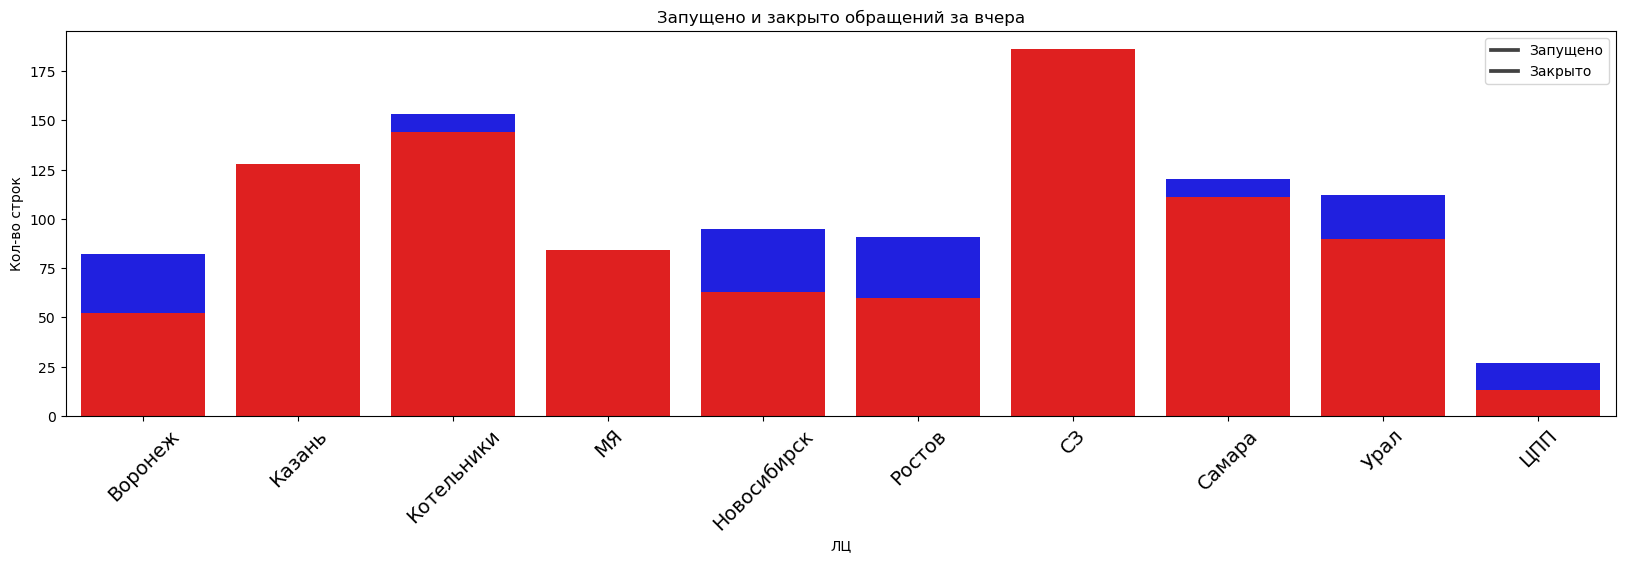

In [36]:
greated_closed_graph = created_closed_yesterday.reset_index()

plt.figure(figsize=(20,5))

ax = sn.barplot(data=greated_closed_graph, x='ЛЦ', y=f"Запущено обращений {yesterday}", color='blue')
sn.barplot(data=greated_closed_graph, x='ЛЦ', y=f"Закрыто обращений {yesterday}", color='red')
plt.xticks(rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title('Запущено и закрыто обращений за вчера')
plt.xlabel('ЛЦ')
plt.ylabel('Кол-во строк')
plt.legend(['Запущено', 'Закрыто'])
plt.show()


In [37]:
greated_closed_graph

,ЛЦ,Запущено обращений 2023-08-23,Закрыто обращений 2023-08-23
0,Воронеж,82,52
1,Казань,105,128
2,Котельники,153,144
3,МЯ,49,84
4,Новосибирск,95,63
5,Ростов,91,60
6,СЗ,174,186
7,Самара,120,111
8,Урал,112,90
9,ЦПП,27,13


#### Создано рекламаций за вчерашний день 

In [38]:
created_closed_yesterday

,Запущено обращений 2023-08-23,Закрыто обращений 2023-08-23
ЛЦ,,
Воронеж,82,52
Казань,105,128
Котельники,153,144
МЯ,49,84
Новосибирск,95,63
Ростов,91,60
СЗ,174,186
Самара,120,111
Урал,112,90


#### Количество рекламаций поэтапно

In [39]:
complianses_in_process

,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,76.0,15.0,112.0
Казань,156.0,31.0,137.0
Котельники,67.0,36.0,84.0
МЯ,31.0,17.0,58.0
Новосибирск,146.0,24.0,81.0
Ростов,68.0,28.0,103.0
Самара,81.0,30.0,111.0
СЗ,190.0,24.0,292.0
Урал,188.0,27.0,68.0


#### Количество рекламаций поэтапно - 2 рабочих дня

In [40]:
complianses_in_process_2d

,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,56.0,6.0,63.0
Казань,113.0,16.0,71.0
Котельники,28.0,16.0,52.0
МЯ,15.0,7.0,38.0
Новосибирск,84.0,16.0,63.0
Ростов,42.0,11.0,37.0
Самара,42.0,17.0,52.0
СЗ,129.0,6.0,168.0
Урал,138.0,18.0,43.0


In [41]:
merged_non_marketable_familiarize_yesterday

,Дата запуска,Дата ответа
ЛЦ,,
Воронеж,2,4
Казань,2,2
Котельники,11,9
Новосибирск,2,4
Ростов,3,3
СЗ,10,7
Самара,7,8
Урал,6,11
ЦПП,3,5
